In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow
from tensorflow import keras
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.ensemble import RandomForestClassifier
import pickle
import numpy as np
from tensorflow.keras.preprocessing import image as tsimage
import matplotlib.pyplot as plt
import random
import hashlib
from keras.layers import Flatten
from skimage.io import imread
import cv2
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D
import filecmp
import itertools
from sklearn.utils import class_weight

In [2]:
name = "4_classes"
working_dir = r"C:\Users\droko\Documents\קורסים\סדנה במדעי הנתונים\פרויקט"

rfm_load_model = True
rfm_save_model = False
rfm_saved_model_path = os.path.join(working_dir, f'RFM_{name}.h5')

overfitted_cnn_load_model = True
overfitted_cnn_save_model = False
overfitted_cnn_train_again = False
overfitted_cnn_saved_model_path = os.path.join(working_dir, f'CNN_overfitted_{name}')
overfitted_cnn_saved_model_fit_results_path = os.path.join(working_dir, f'CNN_overfitted_{name}_History.bin')

overfitted_cnn_load_5epochs_model = True
overfitted_cnn_save_5epochs_model = False
overfitted_cnn_train_5epochs_again = False
overfitted_cnn_saved_5epochs_model_path = os.path.join(working_dir, f'CNN_overfitted_5epochs_{name}')
overfitted_cnn_saved_5epochs_model_fit_results_path = os.path.join(working_dir, f'CNN_overfitted_5epochs_{name}_History.bin')

cnn_load_model = True
cnn_save_model = False
cnn_train_again = False
cnn_saved_model_path = os.path.join(working_dir, f'CNN_{name}')
cnn_saved_model_fit_results_path = os.path.join(working_dir, f'CNN_{name}_History.bin')

cnn_load_5epochs_model = True
cnn_save_5epochs_model = False
cnn_train_5epochs_again = False
cnn_saved_5epochs_model_path = os.path.join(working_dir, f'CNN_5epochs_{name}')
cnn_saved_5epochs_model_fit_results_path = os.path.join(working_dir, f'CNN_5epochs_{name}_History.bin')

cnn_load_10epochs_model = True
cnn_save_10epochs_model = False
cnn_train_10epochs_again = False
cnn_saved_10epochs_model_path = os.path.join(working_dir, f'CNN_10epochs_{name}')
cnn_saved_10epochs_model_fit_results_path = os.path.join(working_dir, f'CNN_10epochs_{name}_History.bin')

resnet_load_model = True
resnet_save_model = False
resnet_train_again = False
pretrained_resnet50v2_saved_model_path = os.path.join(working_dir, f'ResNet50V2_{name}')
pretrained_resnet50v2_saved_model_fit_results_path = os.path.join(working_dir, f'ResNet50V2_{name}_History.bin')

fastai_resnet34_saved_model_path = os.path.join("C:\\Users\\droko\\Documents", f'FastAI_ResNet34_{name}')

# Loading the data

In [3]:
first_data_dir = os.path.join(working_dir, "Imbalanced Tuberculosis and Pneumonia dataset")
second_data_dir = os.path.join(working_dir, "COVID19+PNEUMONIA+NORMAL Chest X-Ray Image Dataset")
third_data_dir = os.path.join(working_dir, "ChestXRays")

In [4]:
normal_dirs = [
    os.path.join(first_data_dir, "Normal"),
    os.path.join(second_data_dir, "NORMAL"),
    os.path.join(third_data_dir, r"test\NORMAL"),
    os.path.join(third_data_dir, r"val\NORMAL"),
    os.path.join(third_data_dir, r"train\NORMAL")
]
covid_dirs = [
    os.path.join(second_data_dir, "COVID")
]
pneumonia_dirs = [
    os.path.join(first_data_dir, "Pneumonia"),
    os.path.join(second_data_dir, "PNEUMONIA"),
    os.path.join(third_data_dir, r"test\PNEUMONIA"),
    os.path.join(third_data_dir, r"val\PNEUMONIA"),
    os.path.join(third_data_dir, r"train\PNEUMONIA")
]
tuberculosis_dirs = [
    os.path.join(first_data_dir, "Tuberculosis")
]

data = [
    (normal_dirs, "Normal"),
    (covid_dirs, "Covid"),
    (pneumonia_dirs, "Pneumonia"),
    (tuberculosis_dirs, "Tuberculosis"),
]

In [5]:
def get_unique_files(paths):
    hash_map = {}

    for path in paths:
        with open(path, 'rb') as f:
            file_hash = hashlib.sha256(f.read()).hexdigest()
        if file_hash not in hash_map:
            hash_map[file_hash] = [path]
        elif not any([filecmp.cmp(f, path) for f in hash_map[file_hash]]):
            hash_map[file_hash].append(path)
    return list(itertools.chain.from_iterable([paths for paths_hash, paths in hash_map.items()]))

labeled_data = {}
for paths, label in data:
    all_label_files = []
    for path in paths:
        files = [os.path.join(path, f) for f in os.listdir(path)]
        all_label_files += files
    labeled_data[label] = get_unique_files(all_label_files)
    print(f"Found {len(labeled_data[label])} {label} images")

Found 10942 Normal images
Found 1537 Covid images
Found 6036 Pneumonia images
Found 1788 Tuberculosis images


In [6]:
def extract_data(paths, label):
    df = pd.DataFrame()
    df["path"] = paths
    df["label"] = [label for i in range(len(paths))]
    return df

labeled_dataframe = pd.DataFrame()
for label, paths in labeled_data.items():
    labeled_dataframe = pd.concat([labeled_dataframe, extract_data(paths, label)], ignore_index=True)

In [7]:
train_df, test_df = train_test_split(labeled_dataframe, test_size=0.2)

In [8]:
train_datagen = ImageDataGenerator(
            rescale=1/255.,
            validation_split=0.1,
            preprocessing_function=tensorflow.image.rgb_to_grayscale)

test_datagen = ImageDataGenerator(
            rescale=1/255.,
            preprocessing_function=tensorflow.image.rgb_to_grayscale)

train_set = train_datagen.flow_from_dataframe(dataframe=train_df, x_col="path", y_col="label", subset="training", class_mode="categorical", seed=0x1337, batch_size=16, target_size=(224, 224))
validation_set = train_datagen.flow_from_dataframe(dataframe=train_df, x_col="path", y_col="label", subset="validation", class_mode="categorical", seed=0x1337, batch_size=16, target_size=(224, 224))
test_set = test_datagen.flow_from_dataframe(dataframe=test_df, x_col="path", y_col="label", class_mode="categorical", seed=0x1337, batch_size=16, target_size=(224, 224))

Found 14618 validated image filenames belonging to 4 classes.
Found 1624 validated image filenames belonging to 4 classes.
Found 4061 validated image filenames belonging to 4 classes.


# First look at the data

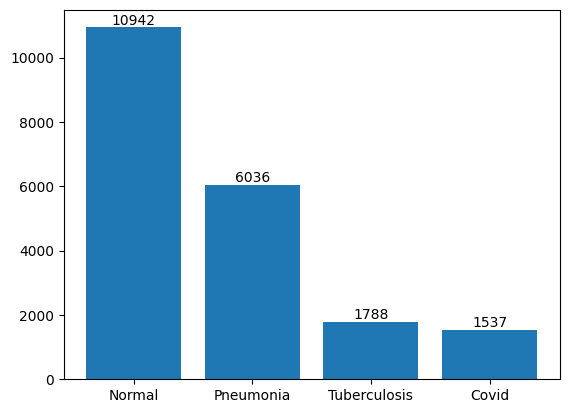

In [9]:
balance_plot_data = labeled_dataframe["label"].value_counts().rename_axis('label').reset_index(name='count')
plt.bar(balance_plot_data["label"], balance_plot_data["count"])
for i, value in enumerate(balance_plot_data["count"]):
    plt.text(i, value, value, ha="center", va="bottom")
plt.show()

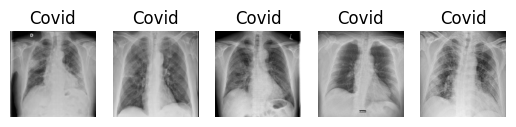

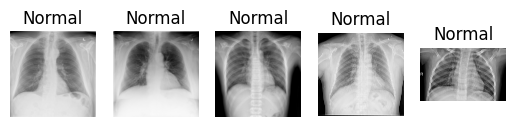

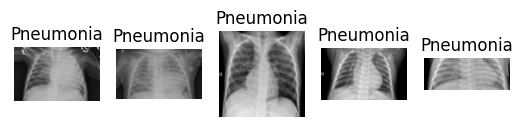

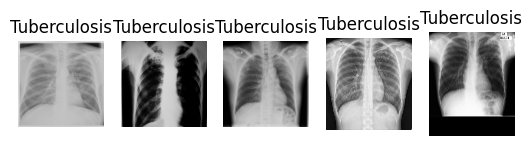

In [10]:
for label, label_data in labeled_dataframe.groupby("label"):
    for i, (image_path, label) in label_data.sample(5).reset_index(drop=True).iterrows():
        image = imread(image_path)
        image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, 5, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(label)

    plt.show()

# Random Forest Model

## Build the model

In [11]:
def image_generator(df):
    for index, row in df.iterrows():
        image = imread(row["path"])
        image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (224, 224))
        image_np = image.flatten()
        yield image_np
        
def label_generator(df):
    for index, row in df.iterrows():
        yield row["label"]

if not rfm_load_model:
    sklearn_train_set, sklearn_train_set_labels = list(image_generator(train_df)), list(label_generator(train_df))
sklearn_test_set, sklearn_test_set_labels = list(image_generator(test_df)), list(label_generator(test_df))

In [12]:
if os.path.exists(rfm_saved_model_path) and rfm_load_model:
    with open(rfm_saved_model_path, "rb") as f:
        rfm_model = pickle.loads(f.read())
else:
    rfc = RandomForestClassifier(n_estimators=100, verbose=10, n_jobs=-1)
    rfm_model = rfc.fit(sklearn_train_set, sklearn_train_set_labels)

In [13]:
if rfm_save_model:
    with open(rfm_saved_model_path, "wb") as f:
        pickle.dump(rfm_model, f)

## Evaluate the model on test set

In [14]:
rfm_test_images_score = rfm_model.score(sklearn_test_set, sklearn_test_set_labels)
print(f"The testing score: {rfm_test_images_score*100}%")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


The testing score: 98.59640482639745%


In [15]:
index_to_label = {v: k for k, v in train_set.class_indices.items()}

In [16]:
def rfm_predict(model, image_path, expected_label):
    image = imread(image_path)
    image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (224, 224))
    image_np = image.flatten()

    result = model.predict([image_np])
    print(f"Model result={result[0]}, expected result={expected_label}]")

samples = test_df.sample(n = 4)
for index, sample in samples.iterrows():
    rfm_predict(rfm_model, sample["path"], sample["label"])

Model result=Covid, expected result=Covid]
Model result=Normal, expected result=Normal]
Model result=Pneumonia, expected result=Pneumonia]
Model result=Pneumonia, expected result=Pneumonia]


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)

# CNN Model

## Build the model

In [19]:
if os.path.exists(overfitted_cnn_saved_model_path) and overfitted_cnn_load_model:
    overfitted_cnn_model = keras.models.load_model(overfitted_cnn_saved_model_path)
    trained = True
else:
    trained = False
    overfitted_cnn_model = keras.Sequential()
    overfitted_cnn_model.add(keras.layers.Flatten())
    overfitted_cnn_model.add(Dense(128, activation="relu"))
    overfitted_cnn_model.add(Dense(64, activation="relu"))
    overfitted_cnn_model.add(Dense(32, activation="relu"))
    overfitted_cnn_model.add(Dropout(0.2))
    overfitted_cnn_model.add(Dense(4, activation="sigmoid"))

    overfitted_cnn_model.compile(optimizer='adam',
                                 loss='categorical_crossentropy',
                                 metrics=['accuracy'])

In [20]:
if os.path.exists(overfitted_cnn_saved_model_fit_results_path) and not overfitted_cnn_train_again and trained:
    with open(overfitted_cnn_saved_model_fit_results_path, "rb") as f:
        overfitted_cnn_history = pickle.load(f)
else:
    train_set.reset()
    validation_set.reset()
    results = overfitted_cnn_model.fit(train_set, epochs=1, validation_data=validation_set)
    overfitted_cnn_history = results.history
    with open(overfitted_cnn_saved_model_fit_results_path, 'wb') as f:
        pickle.dump(overfitted_cnn_history, f)

914/914 [==============================] - 442s 482ms/step - loss: 1.7181 - accuracy: 0.5461 - val_loss: 1.1413 - val_accuracy: 0.5437


In [21]:
if overfitted_cnn_save_model:
    overfitted_cnn_model.save(overfitted_cnn_saved_model_path)

INFO:tensorflow:Assets written to: C:\Users\droko\Documents\קורסים\סדנה במדעי הנתונים\פרויקט\CNN_overfitted_4_classes\assets


INFO:tensorflow:Assets written to: C:\Users\droko\Documents\קורסים\סדנה במדעי הנתונים\פרויקט\CNN_overfitted_4_classes\assets


## Evaluate the model on test set

In [22]:
test_set.reset()
overfitted_cnn_test_loss, overfitted_cnn_test_accuracy = overfitted_cnn_model.evaluate(test_set)
print(f"The testing accuracy is: {overfitted_cnn_test_accuracy*100}%")
print(f"The testing loss is: {overfitted_cnn_test_loss*100}%")

254/254 [==============================] - 58s 228ms/step - loss: 1.1423 - accuracy: 0.5326
The testing accuracy is: 53.26274037361145%
The testing loss is: 114.23343420028687%


In [23]:
def generate_per_class_report(model):
    report = {}
    for group, frame in test_df.groupby("label"):
        group_test_set = test_datagen.flow_from_dataframe(dataframe=frame, x_col="path", y_col="label", class_mode="categorical", seed=0x1337, batch_size=16, target_size=(224, 224))
        group_label = test_set.class_indices[group]
        group_predictions = model.predict(group_test_set)
        tp = sum(group_predictions.argmax(axis=1) == group_label)
        fp = len(frame) - tp
        report[group] = {"tp": tp, "fp": fp}
    return report

def print_report(report):
    for group, results in report.items():
        total = results["tp"] + results["fp"]
        success_rate = float(results["tp"])/total
        print(f"{group}: {success_rate*100}%")

In [24]:
overfitted_cnn_report = generate_per_class_report(overfitted_cnn_model)

Found 304 validated image filenames belonging to 1 classes.
19/19 [==============================] - 2s 106ms/step
Found 2165 validated image filenames belonging to 1 classes.
136/136 [==============================] - 31s 227ms/step
Found 1215 validated image filenames belonging to 1 classes.
76/76 [==============================] - 12s 152ms/step
Found 377 validated image filenames belonging to 1 classes.
24/24 [==============================] - 13s 555ms/step


In [25]:
print_report(overfitted_cnn_report)

Covid: 0.0%
Normal: 99.90762124711317%
Pneumonia: 0.0%
Tuberculosis: 0.0%


# Prediction of an image

In [26]:
def predict(model, image_path):
    test_image = tsimage.load_img(image_path, target_size=(224, 224))
    test_image = tsimage.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    test_image = test_image / 255

    result = model.predict(test_image)
    predicted_class = index_to_label[int(result.argmax(axis=-1))]
    return predicted_class
    
    
samples = test_df.sample(n = 4)
for index, sample in samples.iterrows():
    predicted_class = predict(overfitted_cnn_model, sample["path"])
    print(f"Model result={predicted_class}, expected result={sample['label']}")

1/1 [==============================] - 0s 109ms/step
Model result=Normal, expected result=Pneumonia
1/1 [==============================] - 0s 28ms/step
Model result=Normal, expected result=Pneumonia
1/1 [==============================] - 0s 36ms/step
Model result=Normal, expected result=Normal
1/1 [==============================] - 0s 41ms/step
Model result=Normal, expected result=Normal


# Continue training the model for 5 epochs

In [27]:
trained = False
if os.path.exists(overfitted_cnn_saved_5epochs_model_path) and overfitted_cnn_load_5epochs_model:
    overfitted_cnn_model = keras.models.load_model(overfitted_cnn_saved_5epochs_model_path)
    trained = True

In [28]:
if os.path.exists(overfitted_cnn_saved_5epochs_model_fit_results_path) and not overfitted_cnn_train_5epochs_again and trained:
    with open(overfitted_cnn_saved_5epochs_model_fit_results_path, "rb") as f:
        overfitted_cnn_5epochs_history = pickle.load(f)
else:
    train_set.reset()
    validation_set.reset()
    results = overfitted_cnn_model.fit(train_set, epochs=4, validation_data=validation_set)
    overfitted_cnn_5epochs_history = results.history
    with open(overfitted_cnn_saved_5epochs_model_fit_results_path, 'wb') as f:
        pickle.dump(overfitted_cnn_5epochs_history, f)

Epoch 1/4
914/914 [==============================] - 428s 469ms/step - loss: 1.1132 - accuracy: 0.5400 - val_loss: 1.1125 - val_accuracy: 0.5437
Epoch 2/4
914/914 [==============================] - 410s 448ms/step - loss: 1.1012 - accuracy: 0.5400 - val_loss: 1.1114 - val_accuracy: 0.5437
Epoch 3/4
914/914 [==============================] - 405s 444ms/step - loss: 1.1002 - accuracy: 0.5400 - val_loss: 1.1118 - val_accuracy: 0.5437
Epoch 4/4
914/914 [==============================] - 407s 446ms/step - loss: 1.1002 - accuracy: 0.5400 - val_loss: 1.1117 - val_accuracy: 0.5437


In [29]:
if overfitted_cnn_save_5epochs_model:
    overfitted_cnn_model.save(overfitted_cnn_saved_5epochs_model_path)

INFO:tensorflow:Assets written to: C:\Users\droko\Documents\קורסים\סדנה במדעי הנתונים\פרויקט\CNN_overfitted_5epochs_4_classes\assets


INFO:tensorflow:Assets written to: C:\Users\droko\Documents\קורסים\סדנה במדעי הנתונים\פרויקט\CNN_overfitted_5epochs_4_classes\assets


## Measure the trained model

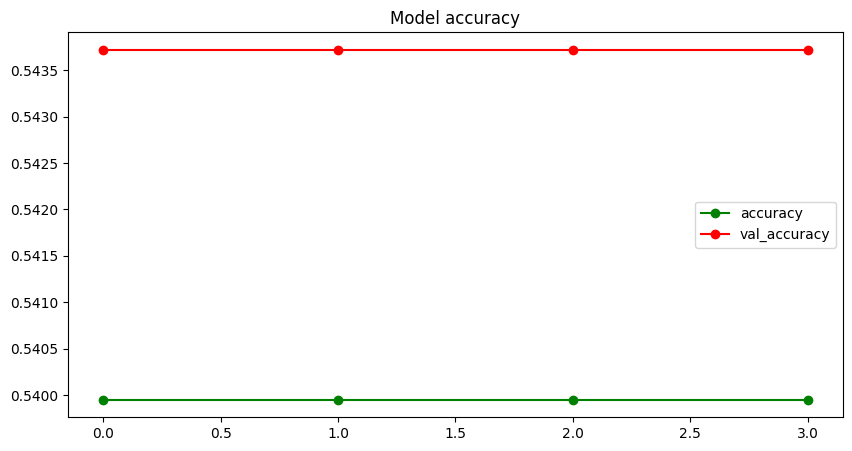

In [30]:
def show_model_plot(history, value):
    plt.figure(figsize=(10, 5))
    plt.title(f"Model {value}")
    plt.plot(history[value], "go-")
    plt.plot(history[f"val_{value}"], "ro-")
    plt.legend([value, f"val_{value}"])
    plt.show()
    
show_model_plot(overfitted_cnn_5epochs_history, "accuracy")

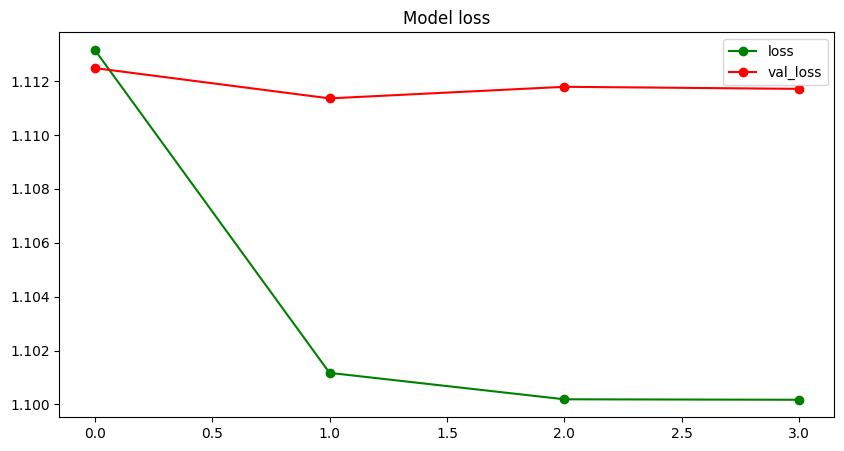

In [31]:
show_model_plot(overfitted_cnn_5epochs_history, "loss")

## Evaluate the model on test set

In [32]:
test_set.reset()
overfitted_cnn_5epochs_test_loss, overfitted_cnn_5epochs_test_accuracy = overfitted_cnn_model.evaluate(test_set)
print(f"The testing accuracy is: {overfitted_cnn_5epochs_test_accuracy*100}%")
print(f"The testing loss is: {overfitted_cnn_5epochs_test_loss*100}%")

254/254 [==============================] - 101s 396ms/step - loss: 1.1115 - accuracy: 0.5329
The testing accuracy is: 53.28736901283264%
The testing loss is: 111.1520528793335%


In [33]:
overfitted_cnn_5epochs_report = generate_per_class_report(overfitted_cnn_model)

Found 304 validated image filenames belonging to 1 classes.
19/19 [==============================] - 3s 150ms/step
Found 2165 validated image filenames belonging to 1 classes.
136/136 [==============================] - 45s 332ms/step
Found 1215 validated image filenames belonging to 1 classes.
76/76 [==============================] - 17s 227ms/step
Found 377 validated image filenames belonging to 1 classes.
24/24 [==============================] - 18s 754ms/step


In [34]:
print_report(overfitted_cnn_5epochs_report)

Covid: 0.0%
Normal: 99.95381062355658%
Pneumonia: 0.0%
Tuberculosis: 0.0%


# Prediction of an image

In [35]:
samples = test_df.sample(n = 4)
for index, sample in samples.iterrows():
    predicted_class = predict(overfitted_cnn_model, sample["path"])
    print(f"Model result={predicted_class}, expected result={sample['label']}")

1/1 [==============================] - 0s 53ms/step
Model result=Normal, expected result=Pneumonia
1/1 [==============================] - 0s 51ms/step
Model result=Normal, expected result=Pneumonia
1/1 [==============================] - 0s 47ms/step
Model result=Normal, expected result=Normal
1/1 [==============================] - 0s 48ms/step
Model result=Normal, expected result=Normal


## Build the model

In [36]:
if os.path.exists(cnn_saved_model_path) and cnn_load_model:
    cnn_model = keras.models.load_model(cnn_saved_model_path)
    trained = True
else:
    trained = False
    cnn_model = keras.Sequential()
    cnn_model.add(Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", input_shape=(224, 224, 3)))
    cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(l=0.01)))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(Dense(4, activation="sigmoid"))
    
#     random.seed(123)
#     cnn_model = Sequential()
#     cnn_model.add(Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", kernel_constraint=unit_norm(), input_shape=(224, 224, 3), kernel_regularizer=l2(l=0.01)))
#     cnn_model.add(MaxPooling2D((2, 2)))
#     cnn_model.add(Dropout(0.4))
#     cnn_model.add(Conv2D(64, (4, 4), activation="relu", kernel_regularizer=l2(l=0.01)))
#     cnn_model.add(MaxPooling2D((2, 2)))
#     cnn_model.add(Dropout(0.4))
#     cnn_model.add(Flatten())
#     cnn_model.add(Dense(512, activation = "relu"))
#     cnn_model.add(Dropout(0.2))
#     cnn_model.add(layers.Dense(4, activation="sigmoid"))
    
#     cnn_model.add(keras.layers.Flatten())
#     cnn_model.add(Dense(128, activation="relu"))
#     cnn_model.add(Dense(64, activation="relu"))
#     cnn_model.add(Dense(32, activation="relu"))
#     cnn_model.add(Dropout(0.2))
#     cnn_model.add(Dense(4, activation="sigmoid"))

    cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [37]:
classes = np.unique(labeled_dataframe["label"])
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=classes,
                                                  y=labeled_dataframe["label"])
weights = {i:class_weights[i] for i in range(len(classes))}

In [38]:
early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)

In [39]:
if os.path.exists(cnn_saved_model_fit_results_path) and not cnn_train_again and trained:
    with open(cnn_saved_model_fit_results_path, "rb") as f:
        cnn_history = pickle.load(f)
else:
    train_set.reset()
    validation_set.reset()
    results = cnn_model.fit(train_set, epochs=1, validation_data=validation_set, callbacks=[early_stop], class_weight=weights)
    cnn_history = results.history
    with open(cnn_saved_model_fit_results_path, 'wb') as f:
        pickle.dump(cnn_history, f)

In [40]:
if cnn_save_model:
    cnn_model.save(cnn_saved_model_path)

## Evaluate the model on test set

In [41]:
test_set.reset()
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_set)
print(f"The testing accuracy is: {cnn_test_accuracy*100}%")
print(f"The testing loss is: {cnn_test_loss*100}%")

254/254 [==============================] - 153s 598ms/step - loss: 0.5423 - accuracy: 0.8537
The testing accuracy is: 85.37306189537048%
The testing loss is: 54.231518507003784%


In [42]:
cnn_report = generate_per_class_report(cnn_model)

Found 304 validated image filenames belonging to 1 classes.
19/19 [==============================] - 9s 454ms/step
Found 2165 validated image filenames belonging to 1 classes.
136/136 [==============================] - 83s 612ms/step
Found 1215 validated image filenames belonging to 1 classes.
76/76 [==============================] - 38s 497ms/step
Found 377 validated image filenames belonging to 1 classes.
24/24 [==============================] - 22s 915ms/step


In [43]:
print_report(cnn_report)

Covid: 96.71052631578947%
Normal: 78.06004618937644%
Pneumonia: 95.22633744855968%
Tuberculosis: 86.47214854111405%


# Prediction of an image

In [44]:
samples = test_df.sample(n = 4)
for index, sample in samples.iterrows():
    predicted_class = predict(cnn_model, sample["path"])
    print(f"Model result={predicted_class}, expected result={sample['label']}")

1/1 [==============================] - 0s 216ms/step
Model result=Pneumonia, expected result=Pneumonia
1/1 [==============================] - 0s 79ms/step
Model result=Pneumonia, expected result=Pneumonia
1/1 [==============================] - 0s 75ms/step
Model result=Normal, expected result=Normal
1/1 [==============================] - 0s 84ms/step
Model result=Normal, expected result=Normal


# Continue training the model for 5 epochs

In [45]:
trained = False
if os.path.exists(cnn_saved_5epochs_model_path) and cnn_load_5epochs_model:
    cnn_model = keras.models.load_model(cnn_saved_5epochs_model_path)
    trained = True

In [46]:
early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)

In [47]:
if os.path.exists(cnn_saved_5epochs_model_fit_results_path) and not cnn_train_5epochs_again and trained:
    with open(cnn_saved_5epochs_model_fit_results_path, "rb") as f:
        cnn_5epochs_history = pickle.load(f)
else:
    train_set.reset()
    validation_set.reset()
    results = cnn_model.fit(train_set, epochs=4, validation_data=validation_set, callbacks=[early_stop], class_weight=weights)
    cnn_5epochs_history = results.history
    with open(cnn_saved_5epochs_model_fit_results_path, 'wb') as f:
        pickle.dump(cnn_5epochs_history, f)

In [48]:
if cnn_save_5epochs_model:
    cnn_model.save(cnn_saved_5epochs_model_path)

## Measure the trained model

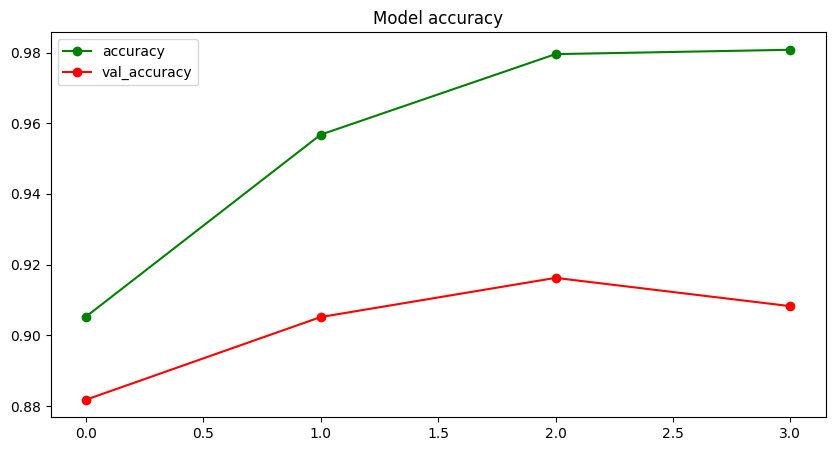

In [49]:
show_model_plot(cnn_5epochs_history, "accuracy")

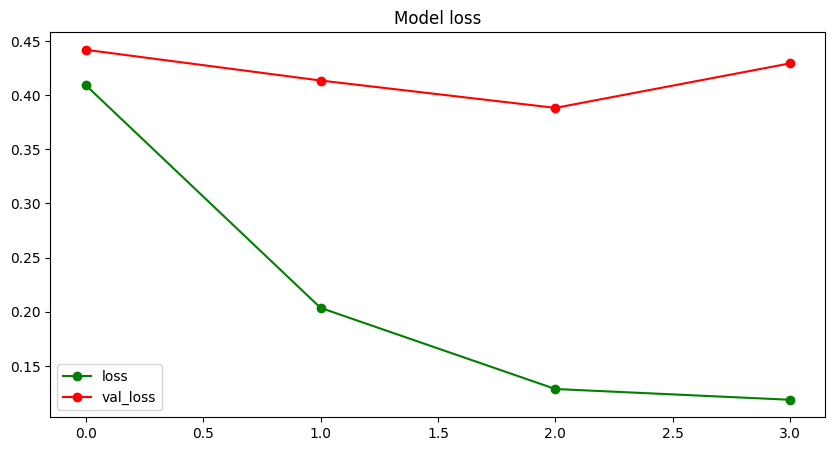

In [50]:
show_model_plot(cnn_5epochs_history, "loss")

## Evaluate the model on test set

In [51]:
test_set.reset()
cnn_5epochs_test_loss, cnn_5epochs_test_accuracy = cnn_model.evaluate(test_set)
print(f"The testing accuracy is: {cnn_5epochs_test_accuracy*100}%")
print(f"The testing loss is: {cnn_5epochs_test_loss*100}%")

254/254 [==============================] - 138s 543ms/step - loss: 0.2313 - accuracy: 0.9574
The testing accuracy is: 95.73996663093567%
The testing loss is: 23.13322275876999%


In [52]:
cnn_5epochs_report = generate_per_class_report(cnn_model)

Found 304 validated image filenames belonging to 1 classes.
19/19 [==============================] - 8s 426ms/step
Found 2165 validated image filenames belonging to 1 classes.
136/136 [==============================] - 73s 535ms/step
Found 1215 validated image filenames belonging to 1 classes.
76/76 [==============================] - 35s 462ms/step
Found 377 validated image filenames belonging to 1 classes.
24/24 [==============================] - 20s 854ms/step


In [53]:
print_report(cnn_5epochs_report)

Covid: 96.38157894736842%
Normal: 94.27251732101617%
Pneumonia: 98.35390946502058%
Tuberculosis: 93.89920424403184%


# Prediction of an image

In [54]:
samples = test_df.sample(n = 4)
for index, sample in samples.iterrows():
    predicted_class = predict(cnn_model, sample["path"])
    print(f"Model result={predicted_class}, expected result={sample['label']}")

1/1 [==============================] - 0s 174ms/step
Model result=Pneumonia, expected result=Pneumonia
1/1 [==============================] - 0s 73ms/step
Model result=Pneumonia, expected result=Pneumonia
1/1 [==============================] - 0s 70ms/step
Model result=Normal, expected result=Normal
1/1 [==============================] - 0s 78ms/step
Model result=Normal, expected result=Normal


# Continue training the model for 10 epochs

In [55]:
trained = False
if os.path.exists(cnn_saved_10epochs_model_path) and cnn_load_10epochs_model:
    cnn_model = keras.models.load_model(cnn_saved_10epochs_model_path)
    trained = True

In [56]:
early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)

In [57]:
if os.path.exists(cnn_saved_10epochs_model_fit_results_path) and not cnn_train_10epochs_again and trained:
    with open(cnn_saved_10epochs_model_fit_results_path, "rb") as f:
        cnn_10epochs_history = pickle.load(f)
else:
    train_set.reset()
    validation_set.reset()
    results = cnn_model.fit(train_set, epochs=5, validation_data=validation_set, callbacks=[early_stop], class_weight=weights)
    cnn_10epochs_history = results.history
    with open(cnn_saved_10epochs_model_fit_results_path, 'wb') as f:
        pickle.dump(cnn_10epochs_history, f)

In [58]:
if cnn_save_10epochs_model:
    cnn_model.save(cnn_saved_10epochs_model_path)

## Measure the trained model

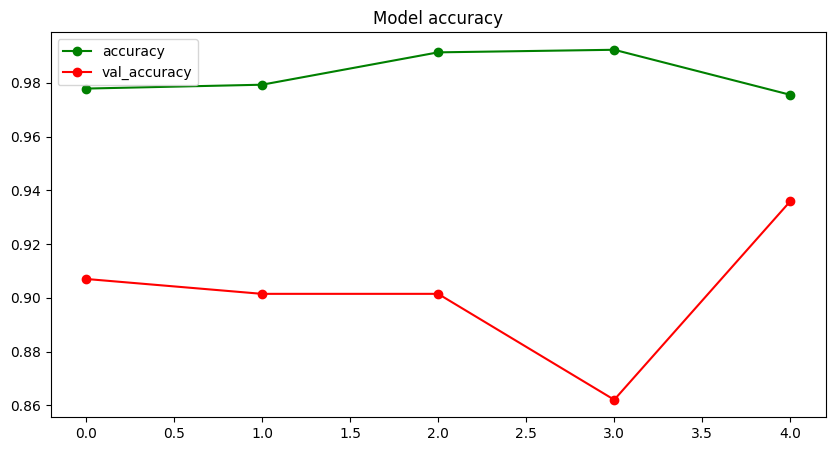

In [59]:
show_model_plot(cnn_10epochs_history, "accuracy")

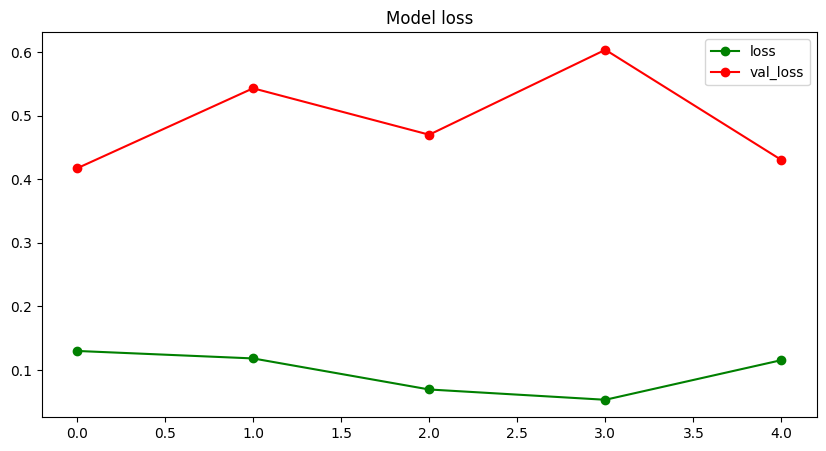

In [60]:
show_model_plot(cnn_10epochs_history, "loss")

## Evaluate the model on test set

In [61]:
test_set.reset()
cnn_10epochs_test_loss, cnn_10epochs_test_accuracy = cnn_model.evaluate(test_set)
print(f"The testing accuracy is: {cnn_10epochs_test_accuracy*100}%")
print(f"The testing loss is: {cnn_10epochs_test_loss*100}%")

254/254 [==============================] - 142s 557ms/step - loss: 0.1452 - accuracy: 0.9815
The testing accuracy is: 98.15316200256348%
The testing loss is: 14.51558917760849%


In [62]:
cnn_10epochs_report = generate_per_class_report(cnn_model)

Found 304 validated image filenames belonging to 1 classes.
19/19 [==============================] - 9s 464ms/step
Found 2165 validated image filenames belonging to 1 classes.
136/136 [==============================] - 74s 547ms/step
Found 1215 validated image filenames belonging to 1 classes.
76/76 [==============================] - 35s 464ms/step
Found 377 validated image filenames belonging to 1 classes.
24/24 [==============================] - 20s 852ms/step


In [63]:
print_report(cnn_10epochs_report)

Covid: 96.71052631578947%
Normal: 98.70669745958429%
Pneumonia: 98.43621399176955%
Tuberculosis: 93.36870026525199%


# Prediction of an image

In [64]:
samples = test_df.sample(n = 4)
for index, sample in samples.iterrows():
    predicted_class = predict(cnn_model, sample["path"])
    print(f"Model result={predicted_class}, expected result={sample['label']}")

1/1 [==============================] - 0s 180ms/step
Model result=Pneumonia, expected result=Pneumonia
1/1 [==============================] - 0s 66ms/step
Model result=Pneumonia, expected result=Pneumonia
1/1 [==============================] - 0s 73ms/step
Model result=Normal, expected result=Normal
1/1 [==============================] - 0s 83ms/step
Model result=Normal, expected result=Normal


# Pretrained ResNet50V2 model

## Build the model

In [65]:
if os.path.exists(pretrained_resnet50v2_saved_model_path) and resnet_load_model:
    resnet_model = keras.models.load_model(pretrained_resnet50v2_saved_model_path)
else:
    base_resnet_model = ResNet50V2(weights="imagenet",
                                   input_shape=(224, 224, 3),
                                   pooling="max",
                                   include_top=False,
                                   classes=4)

    for layer in base_resnet_model.layers:
        layer.trainable = False

### Create more layers on top of the model

In [66]:
if not os.path.exists(pretrained_resnet50v2_saved_model_path) or not resnet_load_model:
    resnet_model = Sequential()
    resnet_model.add(base_resnet_model)
    resnet_model.add(Flatten())

    resnet_model.add(Dense(128, activation="relu"))
    resnet_model.add(Dense(64, activation="relu"))
    resnet_model.add(Dense(32, activation="relu"))
    resnet_model.add(Dropout(0.2))
    resnet_model.add(Dense(4, activation="sigmoid"))

    resnet_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [67]:
early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)

In [68]:
if os.path.exists(pretrained_resnet50v2_saved_model_fit_results_path) and not resnet_train_again:
    with open(pretrained_resnet50v2_saved_model_fit_results_path, "rb") as f:
        resnet_history = pickle.load(f)
else:
    train_set.reset()
    validation_set.reset()
    results = resnet_model.fit(train_set, epochs=10, validation_data=validation_set, callbacks=[early_stop], class_weight=weights) 
    resnet_history = results.history
    with open(pretrained_resnet50v2_saved_model_fit_results_path, 'wb') as f:
        pickle.dump(resnet_history, f)

In [69]:
if resnet_save_model:
    resnet_model.save(pretrained_resnet50v2_saved_model_path)

## Measure the trained model

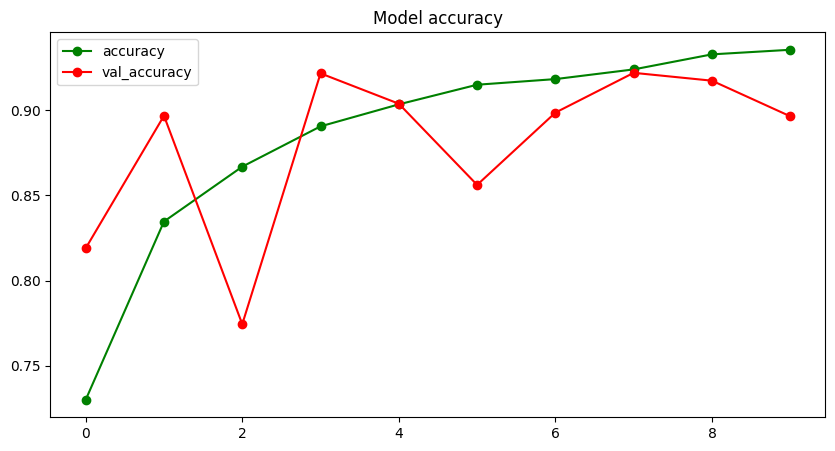

In [70]:
show_model_plot(resnet_history, "accuracy")

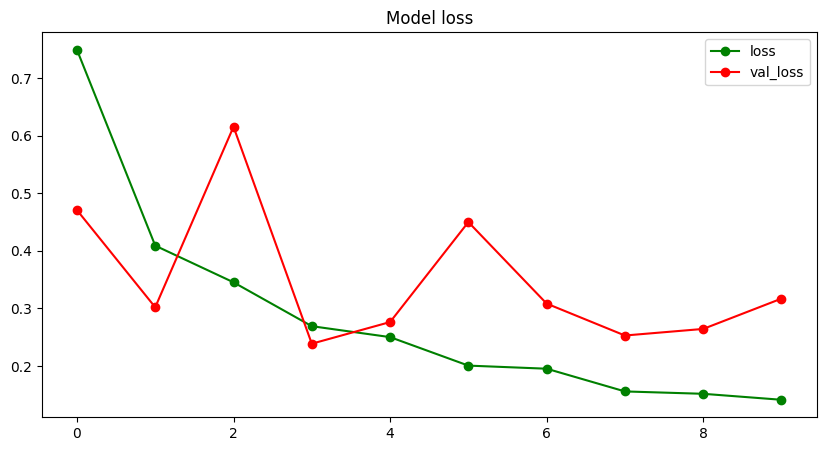

In [71]:
show_model_plot(resnet_history, "loss")

## Evaluate the model on test set

In [72]:
test_set.reset()
resnet_test_loss, resnet_test_accuracy = resnet_model.evaluate(test_set)
print(f"The testing accuracy is: {resnet_test_accuracy*100}%")
print(f"The testing loss is: {resnet_test_loss*100}%")

254/254 [==============================] - 461s 2s/step - loss: 0.2325 - accuracy: 0.9084
The testing accuracy is: 90.83969593048096%
The testing loss is: 23.252062499523163%


In [73]:
resnet_report = generate_per_class_report(resnet_model)

Found 304 validated image filenames belonging to 1 classes.
19/19 [==============================] - 37s 2s/step
Found 2165 validated image filenames belonging to 1 classes.
136/136 [==============================] - 258s 2s/step
Found 1215 validated image filenames belonging to 1 classes.
76/76 [==============================] - 169s 2s/step
Found 377 validated image filenames belonging to 1 classes.
24/24 [==============================] - 55s 2s/step


In [74]:
print_report(resnet_report)

Covid: 98.02631578947368%
Normal: 84.29561200923787%
Pneumonia: 99.67078189300412%
Tuberculosis: 94.16445623342176%


## Prediction of an image

In [75]:
samples = test_df.sample(n = 4)
for index, sample in samples.iterrows():
    predicted_class = predict(resnet_model, sample["path"])
    print(f"Model result={predicted_class}, expected result={sample['label']}")

1/1 [==============================] - 3s 3s/step
Model result=Pneumonia, expected result=Pneumonia
1/1 [==============================] - 0s 167ms/step
Model result=Pneumonia, expected result=Pneumonia
1/1 [==============================] - 0s 175ms/step
Model result=Normal, expected result=Normal
1/1 [==============================] - 0s 223ms/step
Model result=Normal, expected result=Normal


# FastAI

In [77]:
import fastai
import fastai.vision.all as fav
fai_dataframe = labeled_dataframe.copy()
fai_dataframe = fai_dataframe.applymap(lambda x: x.replace("C:\\", "") if isinstance(x, str) else x)
fai_dataframe.head()

,path,label
0,Users\droko\Documents\קורסים\סדנה במדעי הנתונים\פרויקט\Imbalanced Tuberculosis and Pneumonia dataset\Normal\CHNCXR_0001_0.png,Normal
1,Users\droko\Documents\קורסים\סדנה במדעי הנתונים\פרויקט\Imbalanced Tuberculosis and Pneumonia dataset\Normal\CHNCXR_0002_0.png,Normal
2,Users\droko\Documents\קורסים\סדנה במדעי הנתונים\פרויקט\Imbalanced Tuberculosis and Pneumonia dataset\Normal\CHNCXR_0003_0.png,Normal
3,Users\droko\Documents\קורסים\סדנה במדעי הנתונים\פרויקט\Imbalanced Tuberculosis and Pneumonia dataset\Normal\CHNCXR_0004_0.png,Normal
4,Users\droko\Documents\קורסים\סדנה במדעי הנתונים\פרויקט\Imbalanced Tuberculosis and Pneumonia dataset\Normal\CHNCXR_0005_0.png,Normal


In [78]:
tfms = fav.L([fav.Resize([256, 256, 3])])
fai_data = fav.ImageDataLoaders.from_df(fai_dataframe, "C:", item_tfms=tfms, bs=256, seed=0x1337)

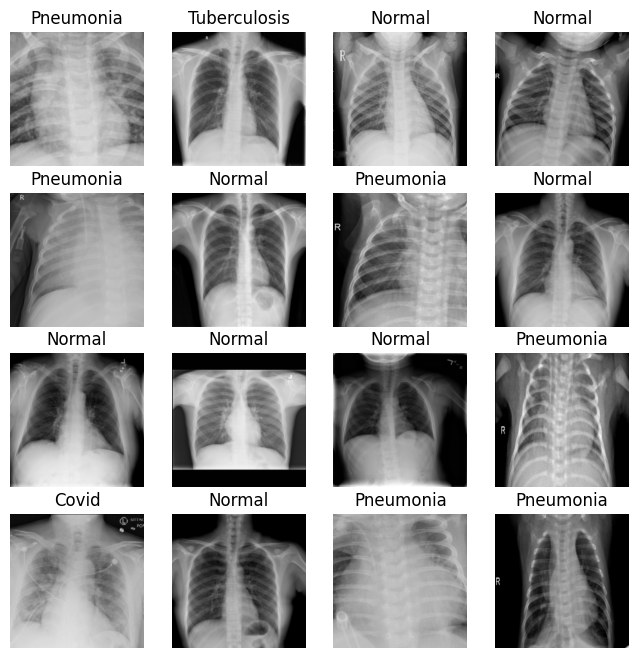

In [79]:
fai_data.show_batch(max_n = 16, figsize = (8,8))

In [ ]:
from pathlib import Path
from fastai.vision.all import *
Path(fastai_resnet34_saved_model_path).mkdir(parents=True, exist_ok=True)

fastai_resnet34 = cnn_learner(fai_data, models.resnet34, metrics = [fav.error_rate , fav.accuracy])
fastai_resnet34.path = Path(fastai_resnet34_saved_model_path)
lr_min, lr_steep, lr_valley, lr_slide = fastai_resnet34.lr_find(suggest_funcs=(minimum, steep, valley, slide))

C:\Users\droko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\fastai\vision\learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
C:\Users\droko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\droko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equi

In [ ]:
print(f"Minimum/10:\t{lr_min:.2e}\nSteepest point:\t{lr_steep:.2e}\nLongest valley:\t{lr_valley:.2e}\nSlide interval:\t{lr_slide:.2e}")

In [ ]:
lr = 1e-1
fastai_resnet34.fit_one_cycle(5, slice(lr/2))

In [ ]:
fastai_resnet34.recorder.plot_losses()